In [57]:
%config Completer.use_jedi = False
# Use auto-complition

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.dates import DateFormatter, AutoDateLocator
import seaborn as sns; sns.set()
from datetime import datetime as dt
dtm = lambda x: dt.strptime(str(x), "%Y-%m") 
elec_raw = pd.read_csv('data-20200131T1110-structure-20190322T1642.csv', header=1)
# Read csv from https://minenergo.gov.ru/opendata

In [59]:
temp_raw = pd.read_csv('wheater_RUS.csv')
# Read csv from http://weatherarchive.ru/Pogoda/Russia

In [60]:
elec_raw.head()

,Период,"Объем выработки электроэнергии, млрд. кВтч"
0,январь 2013,"103,26"
1,февраль 2013,"91,53"
2,март 2013,"97,81"
3,апрель 2013,"85,13"
4,май 2013,"79,08"


In [61]:
elec_raw.rename(columns={"Период": "Period", "Объем выработки электроэнергии, млрд. кВтч": "Elec_gen"})

,Period,Elec_gen
0,январь 2013,"103,26"
1,февраль 2013,"91,53"
2,март 2013,"97,81"
3,апрель 2013,"85,13"
4,май 2013,"79,08"
...,...,...
69,октябрь 2018,"91,85"
70,ноябрь 2018,"98,02"
71,декабрь 2018,"108,06"
72,Всего за 2019 год,"1096,43"


In [62]:
temp_raw.head()

,Date,Temp
0,2013-01,-8.46
1,2013-02,-4.89
2,2013-03,-4.82
3,2013-04,6.85
4,2013-05,16.59


In [63]:
temp_raw.tail()

,Date,Temp
79,2019-08,16.79
80,2019-09,11.11
81,2019-10,5.65
82,2019-11,-4.37
83,2019-12,-6.80


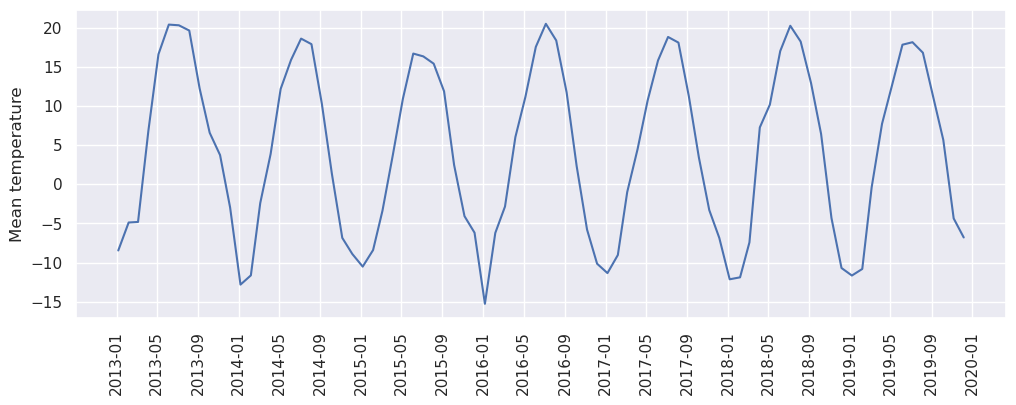

In [64]:
%matplotlib inline
xdata_float = matplotlib.dates.datestr2num(temp_raw.Date)
# Convert string type dates to numeric
fig,ax = plt.subplots(figsize=(12, 4))
plt.plot(xdata_float, temp_raw.Temp)
plt.ylabel('Mean temperature')
plt.xticks(rotation=90)
plt.gca().xaxis.set_minor_formatter(DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(AutoDateLocator (minticks=15, maxticks=25))

In [65]:
elec = elec_raw['Объем выработки электроэнергии, млрд. кВтч'].str.replace(',','.').astype(float)
# Replace ',' on '.' for change type string to float
elec = elec.iloc[:72]
# Chose lines 0-47
elec.size

72

In [66]:
temp_raw['Date'] = pd.to_datetime(temp_raw['Date'], format='%Y-%m')
# Convert string type dates to datetime
date = temp_raw['Date']
date = date.iloc[:72]
# Use 72 line
date.size

72

In [67]:
temp = temp_raw['Temp']
temp = temp.iloc[:72]
temp.size

72

In [68]:
elec_new = pd.concat([date, elec, temp], axis=1)
# Join seies date, elec_gen, temp to DataFrame elec_new
elec_new = elec_new.rename(columns={"Период": "Period", "Объем выработки электроэнергии, млрд. кВтч": "Elec_gen"})

In [69]:
elec_new.head()

,Date,Elec_gen,Temp
0,2013-01-01,103.26,-8.46
1,2013-02-01,91.53,-4.89
2,2013-03-01,97.81,-4.82
3,2013-04-01,85.13,6.85
4,2013-05-01,79.08,16.59


In [70]:
elec_new.tail()

,Date,Elec_gen,Temp
67,2018-08-01,82.87,18.21
68,2018-09-01,82.30,12.91
69,2018-10-01,91.85,6.42
70,2018-11-01,98.02,-4.32
71,2018-12-01,108.06,-10.70


In [71]:
elec_new.isnull().any()

Date        False
Elec_gen    False
Temp        False
dtype: bool

In [72]:
elec_new.describe()

,Elec_gen,Temp
count,72.000000,72.000000
mean,88.608056,4.321389
std,9.566993,10.991471
min,73.960000,-15.270000
25%,79.375000,-5.890000
50%,88.705000,4.175000
75%,95.122500,15.492500
max,108.060000,20.480000


In [73]:
mask_min = elec_new['Elec_gen'].values == 73.960000

In [74]:
elec_new[mask_min]
# Min perfomanse

,Date,Elec_gen,Temp
17,2014-06-01,73.96,15.87


In [75]:
mask_max = elec_new['Elec_gen'].values == 108.06

In [76]:
elec_new[mask_max]
# Max perfomanse

,Date,Elec_gen,Temp
71,2018-12-01,108.06,-10.7


Text(0, 0.5, 'Amount of electricity & Temperature')

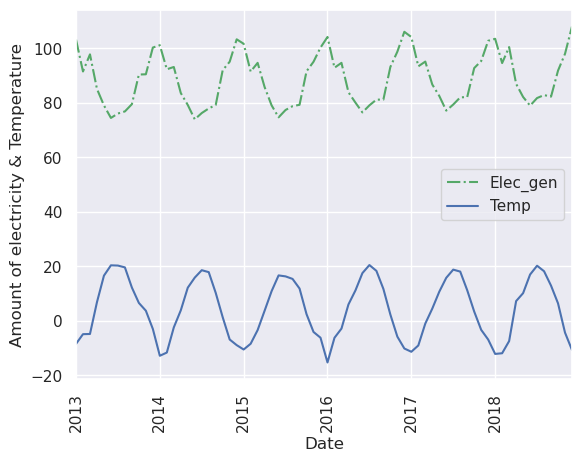

In [77]:
elec_new.plot('Date', rot = 90, style=['-.', '-'], color=['g', 'b'])
plt.ylabel('Amount of electricity & Temperature')

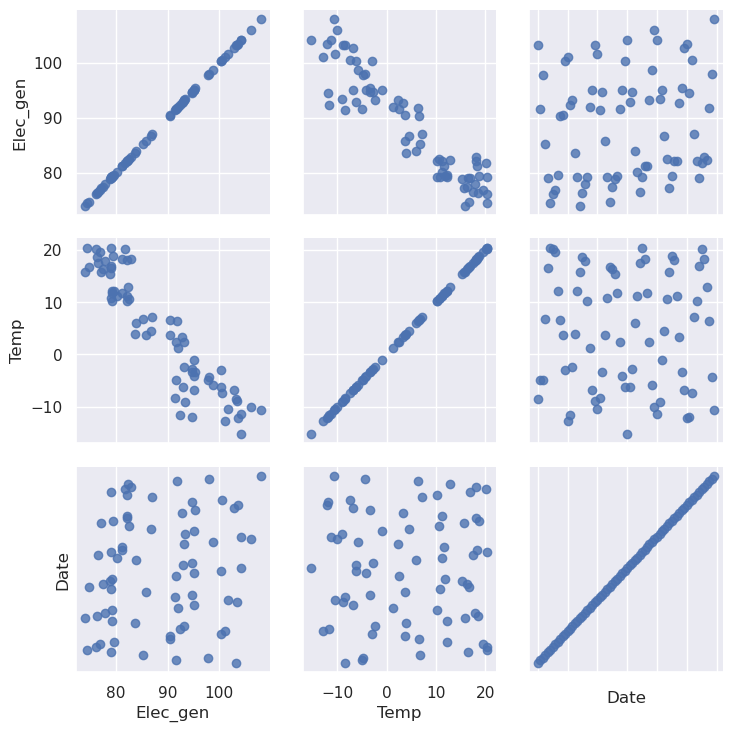

In [78]:
g = sns.PairGrid(elec_new, vars=['Elec_gen', 'Temp', 'Date'], palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())

From the graphs it can be seen that there is an inverse correlation between temperature and power generation.

In [79]:
y = elec_new['Elec_gen']
x = elec_new['Temp']
X = x[:, np.newaxis]
X.shape

/tmp/ipykernel_78/4054812056.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = x[:, np.newaxis]


(72, 1)

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
model = LinearRegression(fit_intercept=True)
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

Text(0, 0.5, 'Amount of electricity')

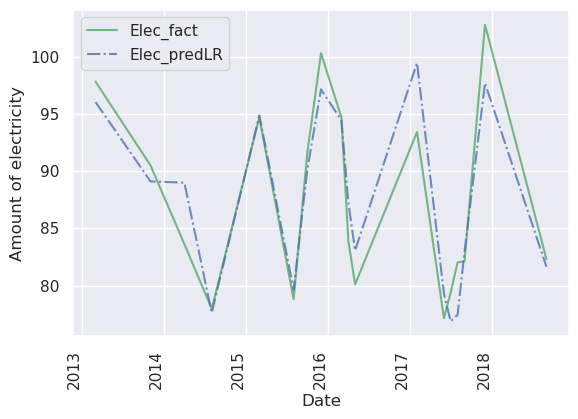

In [81]:
Xtest = pd.Series(Xtest.ravel(), name='Temp')
DFtest = pd.DataFrame({'Temp':Xtest, 'Elec_gen':y_model})
LR = pd.merge(DFtest, elec_new, on='Temp')
LR = LR.rename(columns={"Elec_gen_y": "Elec_fact", "Elec_gen_x": "Elec_predLR"})
LR.plot(x="Date", y=["Elec_fact", "Elec_predLR"], rot = 90, style=['-', '-.'], color=['g', 'b'], alpha=0.8)
plt.ylabel('Amount of electricity')

In [82]:
from sklearn.metrics import r2_score
r2_score_lr = r2_score(ytest, y_model)
print("LR R2 score", r2_score_lr)

LR R2 score 0.8618112798359119


In [83]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve

def PolinomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

Text(0, 0.5, 'score')

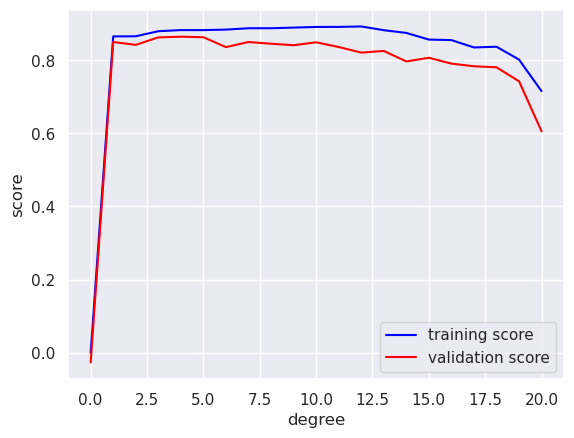

In [84]:
degree = np.arange(0, 21)
train_score, val_score = validation_curve(
    PolinomialRegression(),
    X,
    y,
    param_name="polynomialfeatures__degree",
    param_range=degree,
    cv=7,
)
plt.plot(degree, np.median(train_score, 1), color='blue',
        label='training score')
plt.plot(degree, np.median(val_score, 1), color='red',
        label='validation score')
plt.legend(loc='best')
plt.xlabel('degree')
plt.ylabel('score')
# Best amount of feature is 3

/tmp/ipykernel_78/3819666483.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_model = PolinomialRegression(3).fit(Xtrain, ytrain).predict(Xtest[:, np.newaxis])


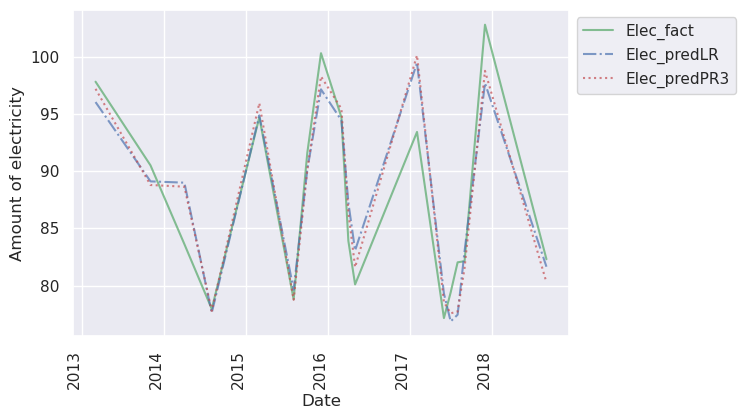

In [85]:
y_model = PolinomialRegression(3).fit(Xtrain, ytrain).predict(Xtest[:, np.newaxis])
Xtest = pd.Series(Xtest.ravel(), name='Temp')
PR = pd.DataFrame({'Temp':Xtest, 'Elec_predPR3':y_model})
DFcomp = pd.merge(PR, LR, on='Temp')
DFcomp.plot(x="Date", y=["Elec_fact", "Elec_predLR", "Elec_predPR3"], rot = 90, 
            style=['-', '-.', ':'], color=['g', 'b', 'r'], alpha=0.7)
plt.ylabel('Amount of electricity')
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [86]:
r2_score_pr3 = r2_score(ytest, y_model)
print("LR R2 score", r2_score_lr)
print("PR3 R2 score", r2_score_pr3)

LR R2 score 0.8618112798359119
PR3 R2 score 0.8853685755200588


In [87]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolinomialRegression(), param_grid, cv=7)

In [88]:
grid.fit(X, y)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])})

In [89]:
grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 3}

/tmp/ipykernel_78/212156790.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_model = model.fit(X, y).predict(Xtest[:, np.newaxis])


(-17.0575, 22.267500000000002, 72.255, 109.765)

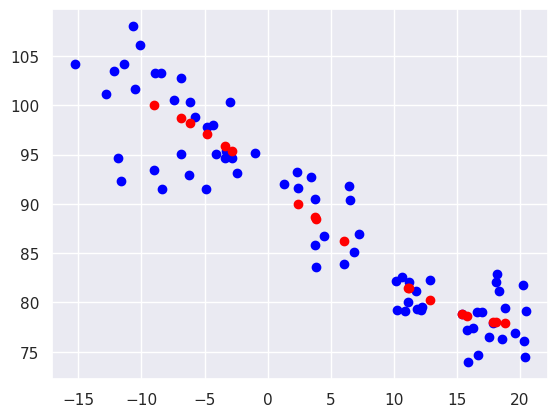

In [90]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y, color='blue', label='Elec_gen_fact')
lim = plt.axis()
y_model = model.fit(X, y).predict(Xtest[:, np.newaxis])
plt.scatter(Xtest.ravel(), y_model, color='red', label='Elec_gen_predict')
plt.axis(lim)

In [91]:
r2_score_prb = r2_score(ytest, y_model)
print("LR R2 score", r2_score_lr)
print("PR3 R2 score", r2_score_pr3)
print("PRB R2 score", r2_score_prb)

LR R2 score 0.8618112798359119
PR3 R2 score 0.8853685755200588
PRB R2 score 0.8896049307561802


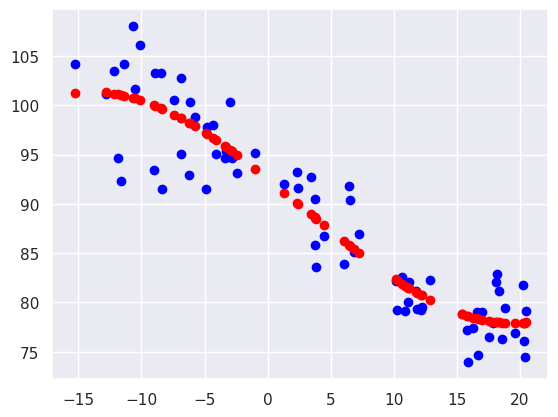

In [92]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(X, y, color='blue', label='Elec_gen_fact')
plt.scatter(X, yfit, color='red', label='Elec_gen_predict')

In [93]:
elec_new['month'] = elec_new['Date'].dt.strftime('%m')
elec_new['month'] = elec_new['month'].astype(np.float64)
elec_new.tail()
# Create column with numbers of the month

,Date,Elec_gen,Temp,month
67,2018-08-01,82.87,18.21,8.0
68,2018-09-01,82.30,12.91,9.0
69,2018-10-01,91.85,6.42,10.0
70,2018-11-01,98.02,-4.32,11.0
71,2018-12-01,108.06,-10.70,12.0


In [94]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i in range(12):
    elec_new[month_list[i]] = elec_new['month'].apply(lambda x: 1 if x == i + 1 else 0)
elec_new = elec_new.drop('month', 1)
elec_new.tail()
# Create column with month

/tmp/ipykernel_78/3539600263.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  elec_new = elec_new.drop('month', 1)


,Date,Elec_gen,Temp,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
67,2018-08-01,82.87,18.21,0,0,0,0,0,0,0,1,0,0,0,0
68,2018-09-01,82.30,12.91,0,0,0,0,0,0,0,0,1,0,0,0
69,2018-10-01,91.85,6.42,0,0,0,0,0,0,0,0,0,1,0,0
70,2018-11-01,98.02,-4.32,0,0,0,0,0,0,0,0,0,0,1,0
71,2018-12-01,108.06,-10.70,0,0,0,0,0,0,0,0,0,0,0,1


In [95]:
column_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Temp']

X = elec_new[column_names]
y = elec_new['Elec_gen']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

model = LinearRegression(fit_intercept=False)
model.fit(Xtrain, ytrain)
DFtest = pd.merge(Xtest, DFcomp, on='Temp')
DFtest['Elec_predLR2'] = model.predict(Xtest)

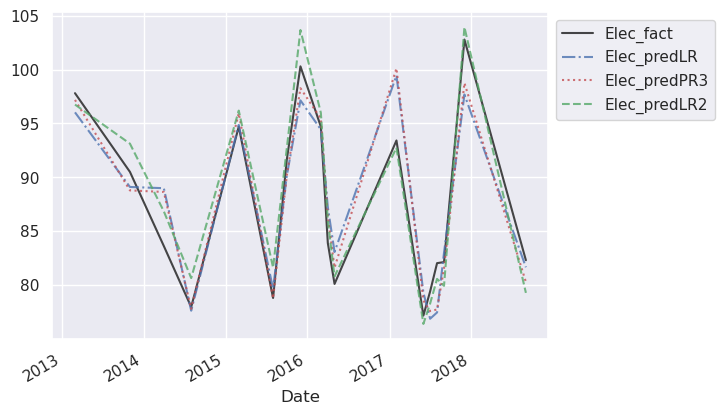

In [96]:
DFtest.plot(x="Date", y=["Elec_fact", "Elec_predLR", "Elec_predPR3", "Elec_predLR2"], 
           style=['-', '-.', ':', '--'], color=['k', 'b', 'r', 'g'], alpha=0.8)
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [97]:
r2_score_lr2 = r2_score(ytest, DFtest['Elec_predLR2'])
print("LR R2 score", r2_score_lr)
print("PR3 R2 score", r2_score_pr3)
print("PRB R2 score", r2_score_prb)
print("LR2 R2 score", r2_score_lr2)

LR R2 score 0.8618112798359119
PR3 R2 score 0.8853685755200588
PRB R2 score 0.8896049307561802
LR2 R2 score 0.9365792031312483


In [98]:
params = pd.Series(model.coef_, index=X.columns)
params

Jan      98.410061
Feb      89.211408
Mar      94.867152
Apr      88.351833
May      85.163997
Jun      82.565539
Jul      85.630345
Aug      87.635639
Sep      84.319430
Oct      93.617166
Nov      94.576566
Dec     101.253064
Temp     -0.391010
dtype: float64

In [99]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
             for i in range(1000)], 0)

In [100]:
print(pd.DataFrame({'effect': params.round(0),
                   'error': err.round(0)}))

      effect  error
Jan     98.0    5.0
Feb     89.0    6.0
Mar     95.0    4.0
Apr     88.0    5.0
May     85.0    3.0
Jun     83.0    3.0
Jul     86.0    5.0
Aug     88.0    4.0
Sep     84.0    4.0
Oct     94.0    3.0
Nov     95.0    3.0
Dec    101.0    6.0
Temp    -0.0    0.0


In [101]:
from sklearn.ensemble import RandomForestRegressor
#tuned_parameters = {'n_estimators': [500, 600, 700], 'min_samples_split': [3, 4, 5]}
#grid = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=7, 
                   #n_jobs=-1, verbose=1)
#grid.fit(X, y)
#grid.best_params_

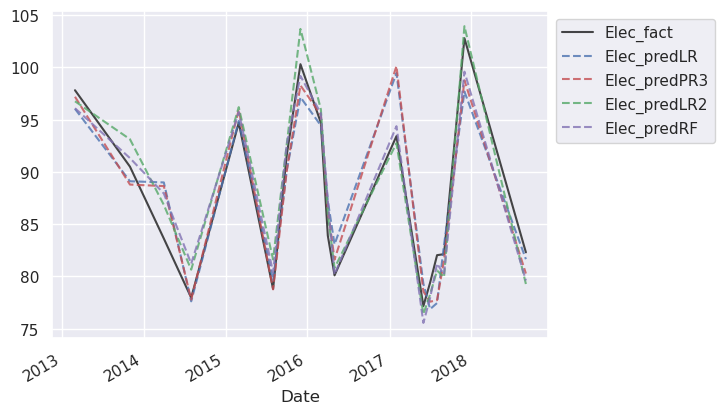

In [102]:
forest = RandomForestRegressor(n_estimators=600, min_samples_split=4)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
forest.fit(Xtrain, ytrain)
DFnew = pd.merge(Xtest, DFtest)
DFnew['Elec_predRF'] = forest.predict(Xtest)
DFnew.plot(x="Date", y=["Elec_fact", "Elec_predLR", "Elec_predPR3", "Elec_predLR2", "Elec_predRF"], 
           style=['-', '--', '--', '--', '--'], color=['k', 'b', 'r', 'g', 'm'], alpha=0.8)
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [103]:
r2_score_rf = r2_score(ytest, DFnew['Elec_predRF'])
print("LR R2 score", r2_score_lr)
print("PR3 R2 score", r2_score_pr3)
print("PRB R2 score", r2_score_prb)
print("LR2 R2 score", r2_score_lr2)
print("RF R2 score", r2_score_rf)

LR R2 score 0.8618112798359119
PR3 R2 score 0.8853685755200588
PRB R2 score 0.8896049307561802
LR2 R2 score 0.9365792031312483
RF R2 score 0.9336177331770178


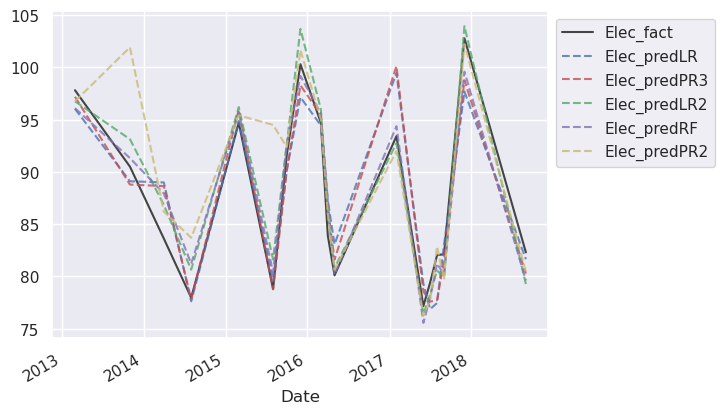

In [104]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
DFnew['Elec_predPR2'] = PolinomialRegression(2).fit(Xtrain, ytrain).predict(Xtest)
DFnew.plot(x="Date", y=["Elec_fact", "Elec_predLR", "Elec_predPR3", "Elec_predLR2", "Elec_predRF", "Elec_predPR2"], 
           style=['-', '--', '--', '--', '--', '--'], color=['k', 'b', 'r', 'g', 'm', 'y'], alpha=0.8)
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [105]:
import dill as pickle
filename = 'model_v1.pk'

In [106]:
with open('model_v1.pk','rb') as f:
    loaded_model = pickle.load(f)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [107]:
loaded_model.predict(Xtest)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([ 80.64438808,  80.56618617,  93.12201005,  79.27149674,
        76.38758814,  96.19267454,  85.9979558 ,  78.27936565,
        92.65919287, 103.93538988,  80.80033099,  81.61800184,
        96.75181818,  92.7461341 , 103.67341349,  95.98152938,
        86.84253641,  79.92448267])